# Introduction

In this notebook I solve $-u'' = f$ on an adapted mesh, adapted using $M = 1 + u^2,$ using a manual MP-Iteration and the FieldSplit MP-Iteration to compare.

##### June 2025

In [1]:
# install firedrake

# hide output
%%capture

# try:
#     import firedrake
# except ImportError:
#     !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
#     import firedrake


try:
    from firedrake import *
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    from firedrake import *

In [2]:
# Code in this cell makes plots appear an appropriate size and resolution in the browser window

%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (11, 6)

In [3]:
# import firedrake tools

from firedrake import *
import numpy as np
import matplotlib.pyplot as plt # firedrake makes use of matplotlib tools
from firedrake.pyplot import tripcolor, tricontour, triplot #firedrake plotting
from IPython.display import display
from mpl_toolkits import mplot3d
from scipy.interpolate import interp1d
import sympy as sp
import scipy as sci

# Setup and Exact u

In [4]:
# SETUP
#################################################

# Grid size and epsilon
N = 50
eps = Constant(0.01)

# solver parameters

lu_params = {
    'snes_type': 'ksponly',
    'snes_monitor': None,
    'mat_type': 'aij',
    'ksp_type': 'preonly',
    'pc_type': 'lu',
}

mesh_params = {
    'snes_type': 'ksponly',
    'snes_monitor': None,
    'mat_type': 'aij',
    'ksp_type': 'richardson',
    # 'ksp_richardson_scale': 0.5,
    'pc_type': 'lu',
}




# Initialize uniform mesh for xi
xi_mesh = UnitIntervalMesh(N)
xi_coord = SpatialCoordinate(xi_mesh)[0]


# Our function spaces
V = FunctionSpace(xi_mesh, "CG", 2)

# Set initial x(xi) to be uniform grid
x_old = Function(V)
x_old.interpolate(xi_coord)


# permute x_old to order coordinates
perm_x = np.argsort(x_old.dat.data[:])


# Set exact solution
top = (1 - exp(1 - 1/eps))*exp(-x_old/eps) + (exp(1) - exp(-1/eps))*exp((x_old-1)/eps)
bottom = (eps**2 - 1) * ( 1 - exp(-2/eps) )
sub = exp(x_old)/(eps**2 - 1)
u_exact_xold = top/bottom - sub



# Compute f for -u'' = f

In [5]:
# symbolic u
xs, eps = sp.symbols('xs, eps')


# Define exact u symbolically
top = (1 - sp.exp(1 - 1/eps)) * sp.exp(-xs/eps) + (sp.exp(1) - sp.exp(-1/eps)) * sp.exp((xs - 1)/eps)
bottom = (eps**2 - 1) * (1 - sp.exp(-2/eps))
sub = sp.exp(xs) / (eps**2 - 1)
u_s = top / bottom - sub

# Take second derivative
du2_dx2 = sp.diff(u_s, xs, 2)
sp.simplify(du2_dx2)

-(eps**2*(exp(2/eps) - 1)*exp(xs*(eps + 1)/eps) - (-(exp((eps - 1)/eps) - 1)*exp(1/eps) + (exp((eps + 1)/eps) - 1)*exp((2*xs - 1)/eps))*exp(1/eps))*exp(-xs/eps)/(eps**2*(eps**2 - 1)*(exp(2/eps) - 1))

In [6]:
str((-1)*sp.simplify(du2_dx2))

'(eps**2*(exp(2/eps) - 1)*exp(xs*(eps + 1)/eps) - (-(exp((eps - 1)/eps) - 1)*exp(1/eps) + (exp((eps + 1)/eps) - 1)*exp((2*xs - 1)/eps))*exp(1/eps))*exp(-xs/eps)/(eps**2*(eps**2 - 1)*(exp(2/eps) - 1))'

In [7]:
eps = Constant(0.01)
f =(eps**2*(exp(2/eps) - 1)*exp(x_old*(eps + 1)/eps) -\
    (-(exp((eps - 1)/eps) - 1)*exp(1/eps) +\
     (exp((eps + 1)/eps) - 1)*exp((2*x_old - 1)/eps))*exp(1/eps))*exp(-x_old/eps)/(eps**2*(eps**2 - 1)*(exp(2/eps) - 1))

# Starting Physical Solve on Uniform Mesh

  0 SNES Function norm 1.594094380061e+02
  1 SNES Function norm 4.725702473703e-12




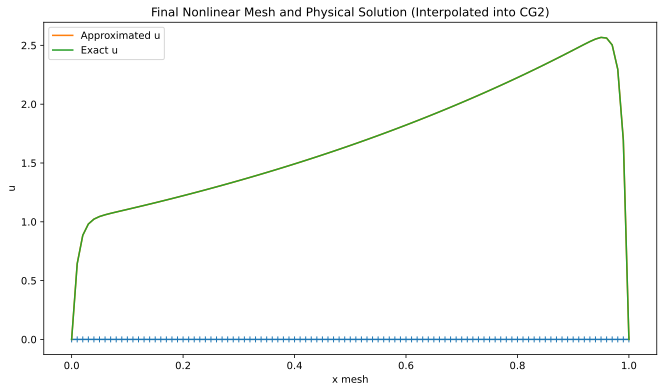

In [8]:
# PHYSICAL SOLVE
##############################


# Test and Trial Functions
u = TrialFunction(V)
v = TestFunction(V)

# Jacobian of x
Jx = x_old.dx(0) #dx/dxi


# Set the bilinear and linear forms of the weak form
u_deriv = (1/Jx) * u.dx(0) # transform to du/dx
v_deriv = (1/Jx) * v.dx(0) # transform to dv/dx
a = (u_deriv * v_deriv) * Jx * dx # transform dxi to dx
L = ( f * v ) * Jx * dx #transform dxi to dx


# Set the BC's
bcs = [DirichletBC(V, Constant(0), 1), DirichletBC(V, Constant(0), 2)]


# Solve
u = Function(V)
solve( a==L, u, bcs = bcs, solver_parameters = lu_params)

print()
print()


# Plot
plt.plot(x_old.dat.data[perm_x], np.zeros_like(x_old.dat.data[perm_x]), marker = "|")
plt.plot(x_old.dat.data[perm_x], Function(V).interpolate(u).dat.data[perm_x], label = "Approximated u")
plt.plot(x_old.dat.data[perm_x], Function(V).interpolate(u_exact_xold).dat.data[perm_x], label = "Exact u")
plt.title("Final Nonlinear Mesh and Physical Solution (Interpolated into CG2)")
plt.xlabel("x mesh")
plt.ylabel("u")
plt.legend()
plt.show()
print()
print()
print()

# Save current state for guesses!

In [9]:
x_guess = Function(V)
x_guess.dat.data[:] = x_old.dat.data[:]

u_guess = Function(V)
u_guess.dat.data[:] = u.dat.data[:]

# Manual MP-Iteration




MP ITERATION NUMBER 1
__________________________________________________




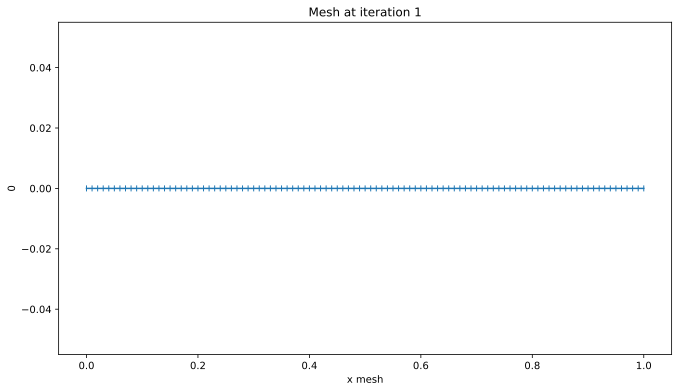

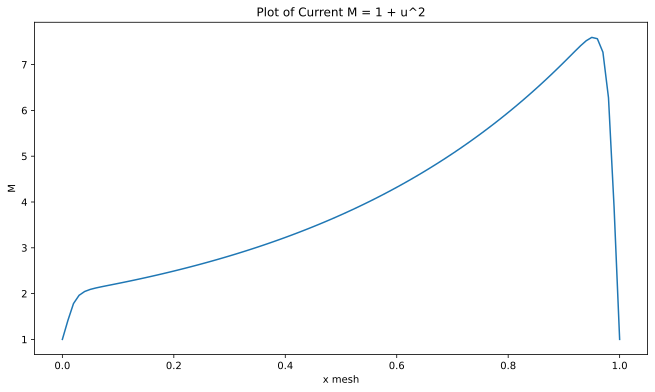



mesh solve
norm(u) before =  0.5773502691896258

  0 SNES Function norm 2.877130220024e+02
  1 SNES Function norm 1.166894489886e-12

norm(u) after =  0.6709599664690026


physical solve

norm(u) before =  1.7526598909090965

  0 SNES Function norm 1.327732734691e+02
  1 SNES Function norm 1.895319271445e+01

norm(u) after =  1.9470570639387785





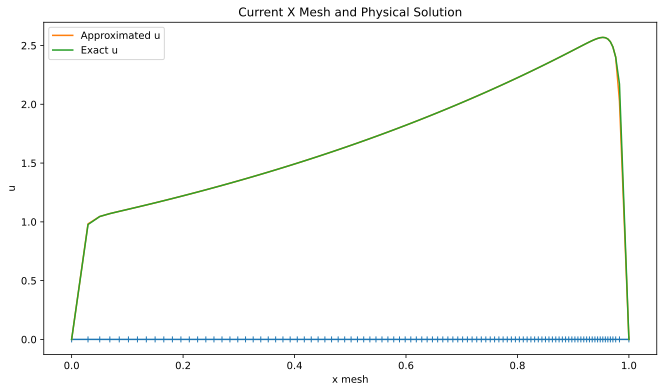







MP ITERATION NUMBER 2
__________________________________________________




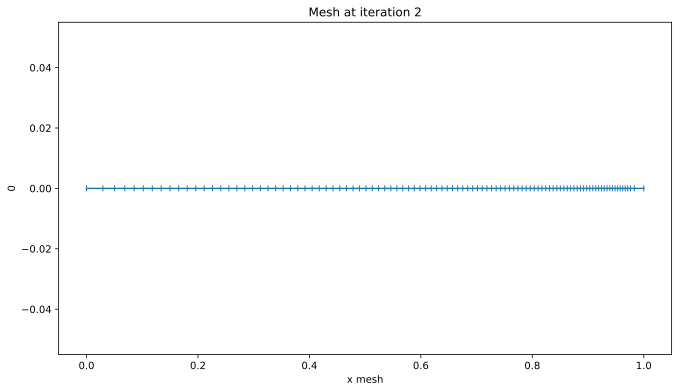

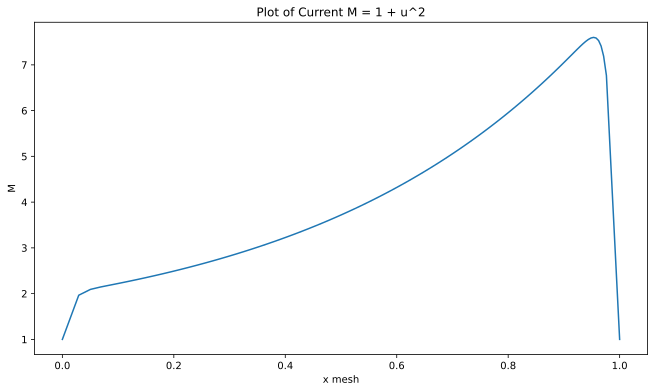



mesh solve
norm(u) before =  0.6709599664690026

  0 SNES Function norm 3.266938849136e+02
  1 SNES Function norm 1.308978389574e-12

norm(u) after =  0.6706852732614959


physical solve

norm(u) before =  1.9470570639387785

  0 SNES Function norm 1.327331482288e+02
  1 SNES Function norm 2.106374408764e+01

norm(u) after =  1.945575180948466





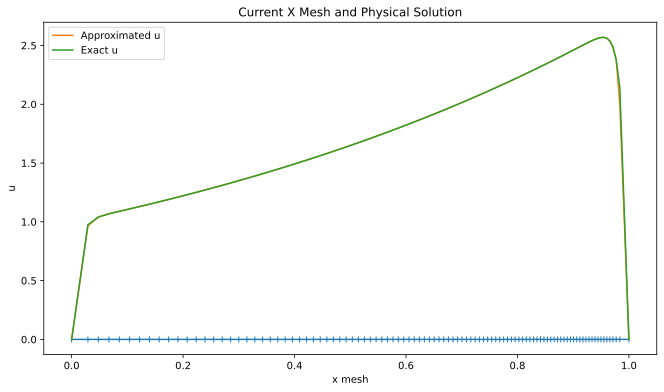







MP ITERATION NUMBER 3
__________________________________________________




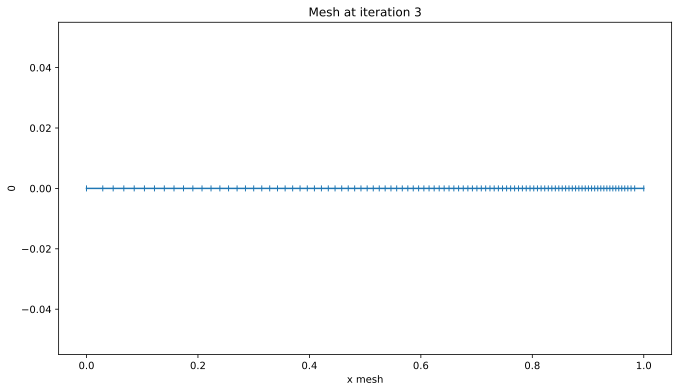

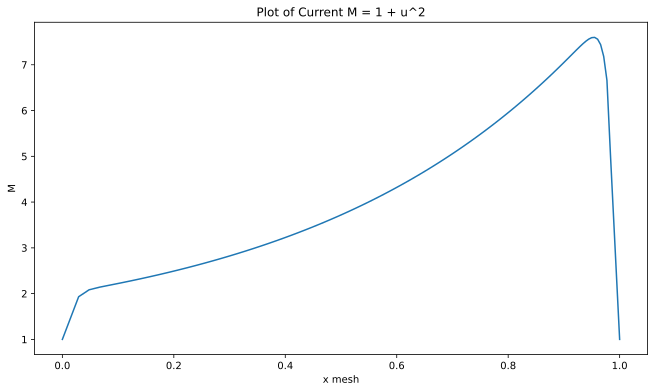



mesh solve
norm(u) before =  0.6706852732614959

  0 SNES Function norm 3.222043331575e+02
  1 SNES Function norm 1.302226847998e-12

norm(u) after =  0.6683452157230317


physical solve

norm(u) before =  1.945575180948466

  0 SNES Function norm 1.325090502523e+02
  1 SNES Function norm 2.036577353852e+01

norm(u) after =  1.9415010518604543





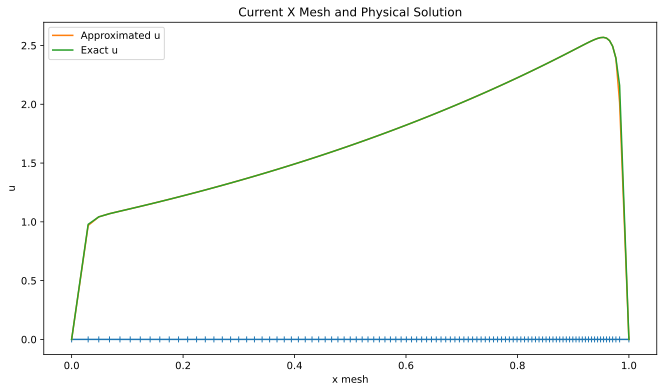







MP ITERATION NUMBER 4
__________________________________________________




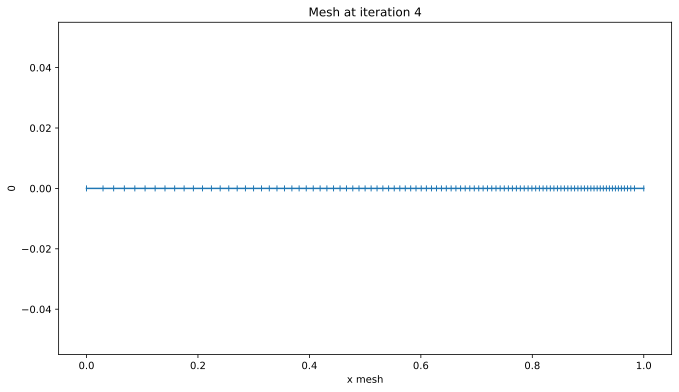

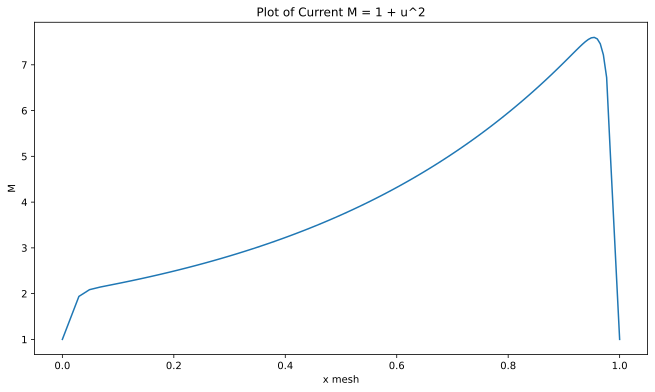



mesh solve
norm(u) before =  0.6683452157230317

  0 SNES Function norm 3.247758772044e+02
  1 SNES Function norm 1.376533718306e-12

norm(u) after =  0.6682938517844201


physical solve

norm(u) before =  1.9415010518604543

  0 SNES Function norm 1.326080150720e+02
  1 SNES Function norm 2.077123533899e+01

norm(u) after =  1.9410698818446113





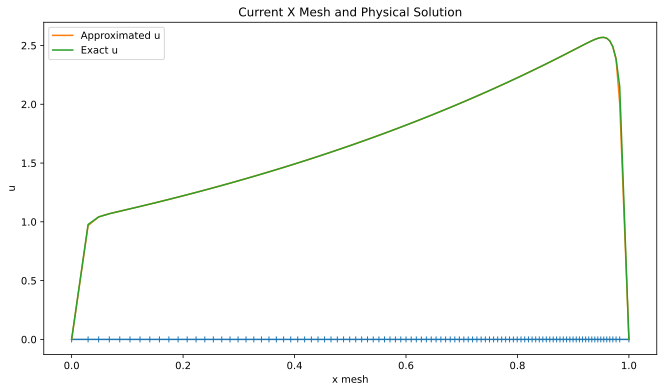







MP ITERATION NUMBER 5
__________________________________________________




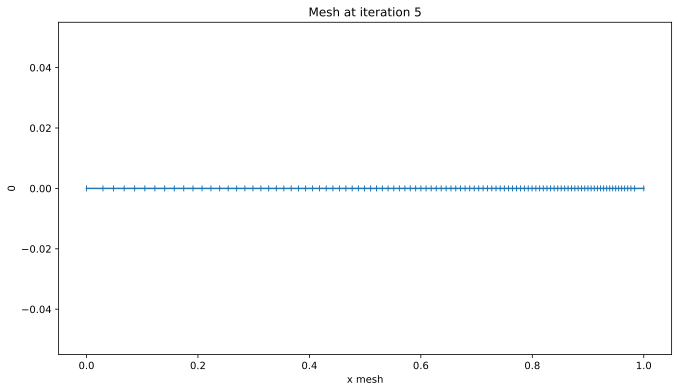

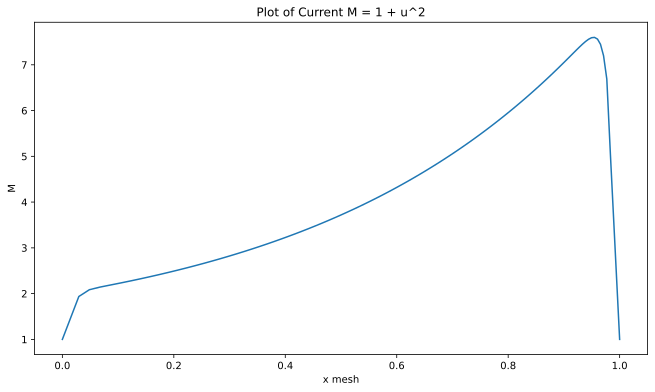



mesh solve
norm(u) before =  0.6682938517844201

  0 SNES Function norm 3.233746851631e+02
  1 SNES Function norm 1.463815715864e-12

norm(u) after =  0.6683461702427935


physical solve

norm(u) before =  1.9410698818446113

  0 SNES Function norm 1.325918134424e+02
  1 SNES Function norm 2.055431490105e+01

norm(u) after =  1.941299274369509





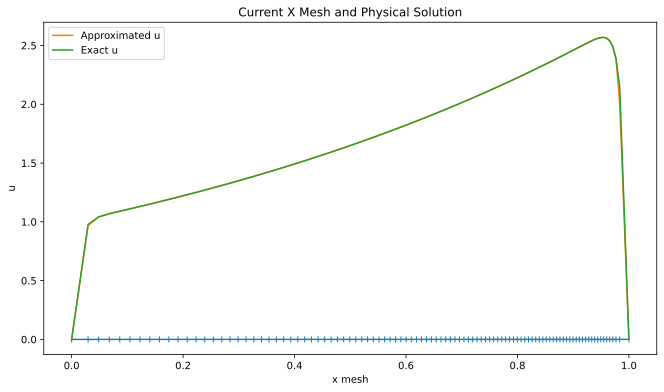







MP ITERATION NUMBER 6
__________________________________________________




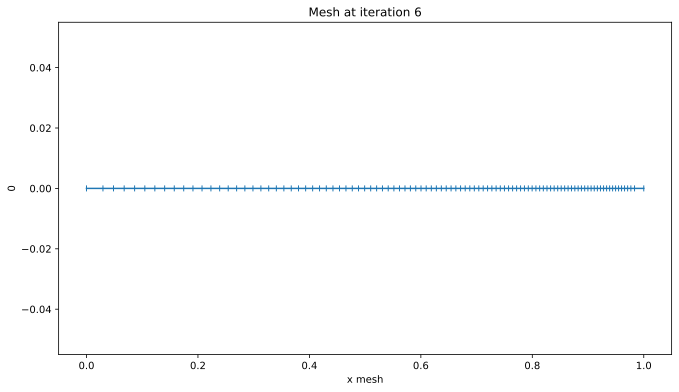

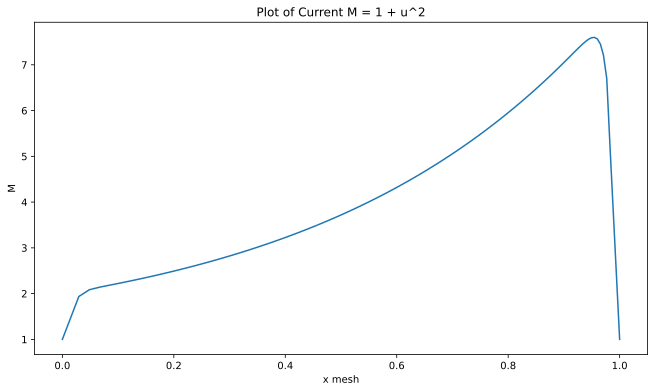



mesh solve
norm(u) before =  0.6683461702427935

  0 SNES Function norm 3.239050237374e+02
  1 SNES Function norm 1.385337553564e-12

norm(u) after =  0.6683849906461724


physical solve

norm(u) before =  1.941299274369509

  0 SNES Function norm 1.325987624525e+02
  1 SNES Function norm 2.063668851095e+01

norm(u) after =  1.9413265246093168





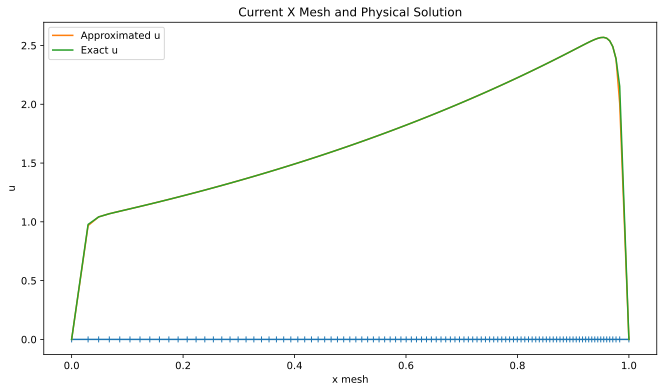







MP ITERATION NUMBER 7
__________________________________________________




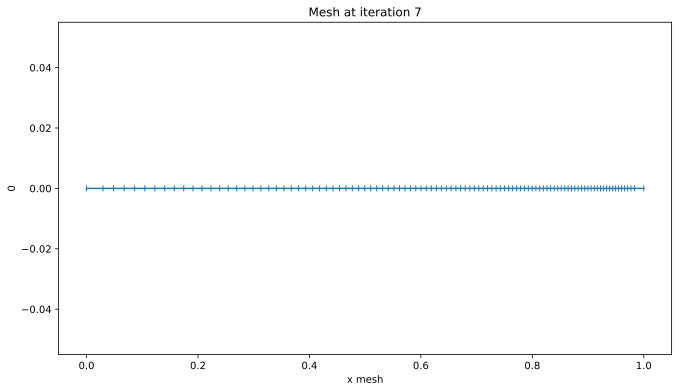

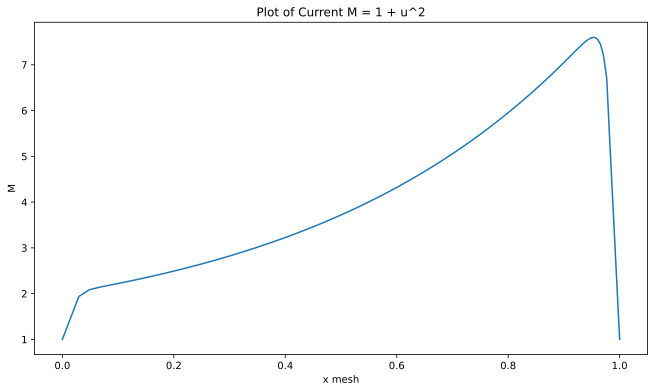



mesh solve
norm(u) before =  0.6683849906461724

  0 SNES Function norm 3.236897778165e+02
  1 SNES Function norm 1.441611733879e-12

norm(u) after =  0.6683667652257695


physical solve

norm(u) before =  1.9413265246093168

  0 SNES Function norm 1.325945329583e+02
  1 SNES Function norm 2.060316265116e+01

norm(u) after =  1.9413130660085605





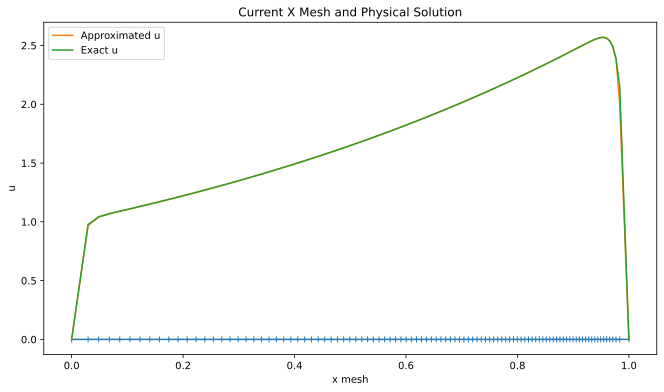







MP ITERATION NUMBER 8
__________________________________________________




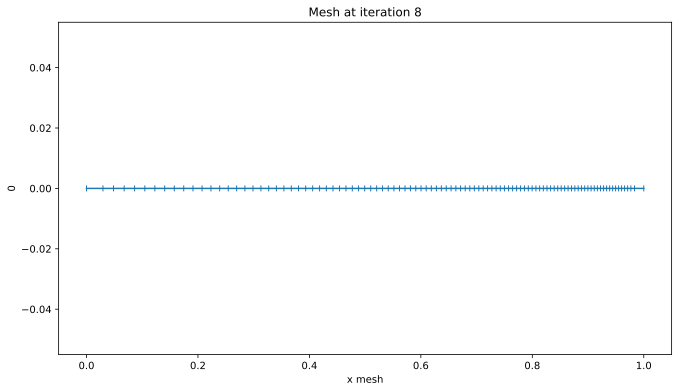

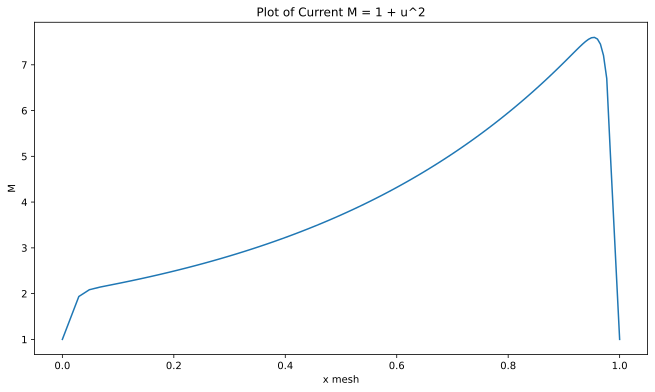



mesh solve
norm(u) before =  0.6683667652257695

  0 SNES Function norm 3.237883295685e+02
  1 SNES Function norm 1.451116587063e-12

norm(u) after =  0.6683717935541645


physical solve

norm(u) before =  1.9413130660085605

  0 SNES Function norm 1.325963782833e+02
  1 SNES Function norm 2.061852298693e+01

norm(u) after =  1.9413128462358322





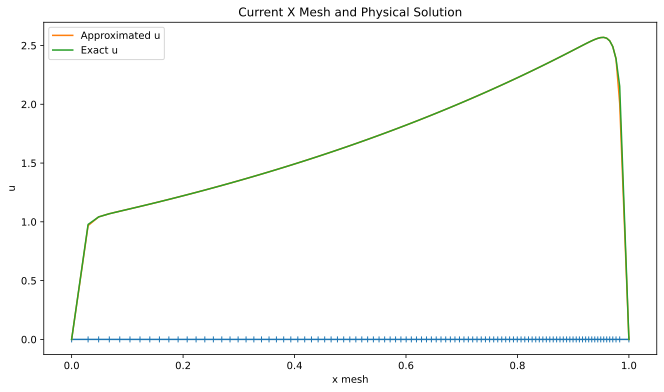







MP ITERATION NUMBER 9
__________________________________________________




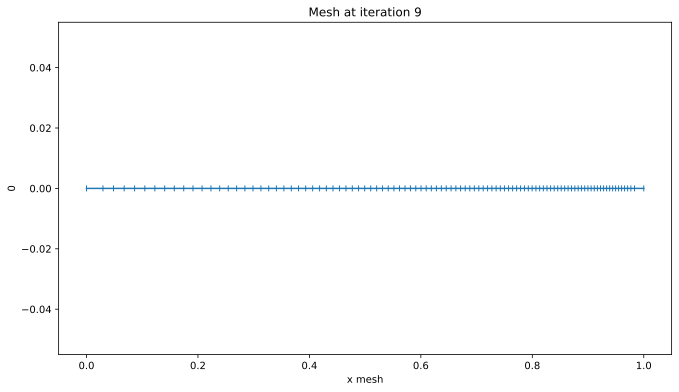

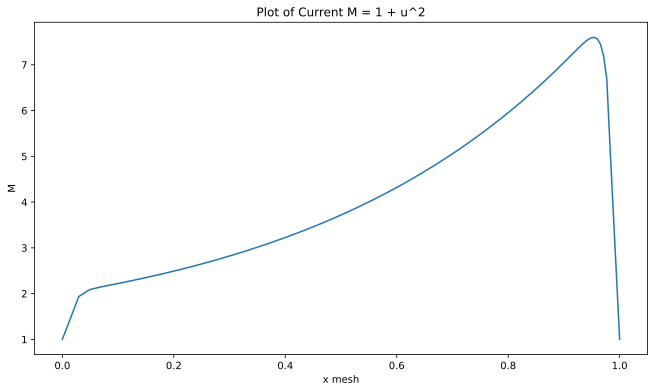



mesh solve
norm(u) before =  0.6683717935541645

  0 SNES Function norm 3.237442792537e+02
  1 SNES Function norm 1.266080969241e-12

norm(u) after =  0.6683695759034829


physical solve

norm(u) before =  1.9413128462358322

  0 SNES Function norm 1.325956280929e+02
  1 SNES Function norm 2.061166638943e+01

norm(u) after =  1.941312880989069





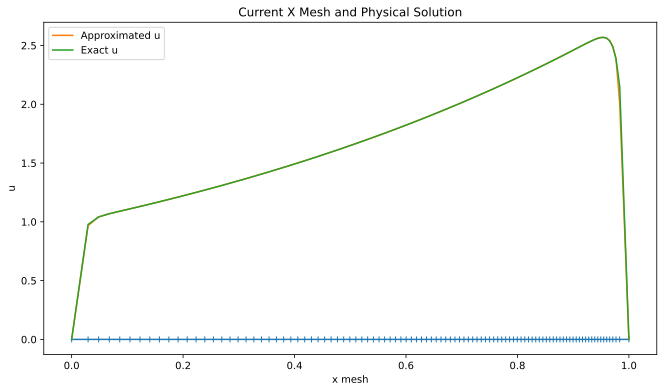







MP ITERATION NUMBER 10
__________________________________________________




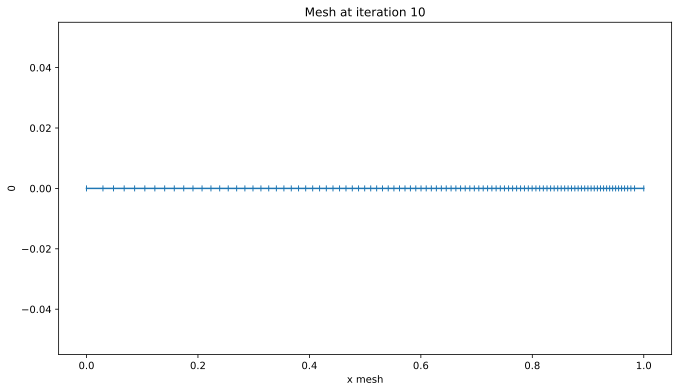

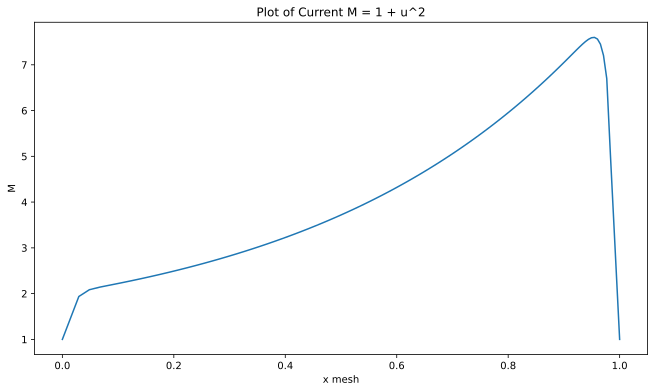



mesh solve
norm(u) before =  0.6683695759034829

  0 SNES Function norm 3.237634254001e+02
  1 SNES Function norm 1.526916005851e-12

norm(u) after =  0.668370701186545


physical solve

norm(u) before =  1.941312880989069

  0 SNES Function norm 1.325959599845e+02
  1 SNES Function norm 2.061464701858e+01

norm(u) after =  1.9413131747188288





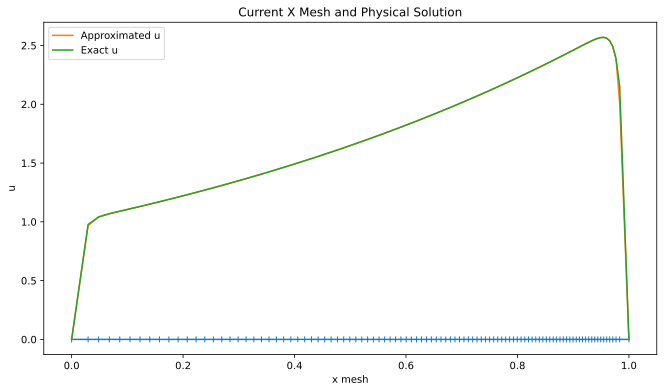

In [10]:
# MP ITERATION
###############################################################

MPIter = 10

for i in range(MPIter):


  print()
  print()
  print()
  print('MP ITERATION NUMBER', i+1)
  print("_"*50)
  print()
  print()


  # plot the mesh
  plt.plot(x_old.dat.data[perm_x], np.zeros_like(x_old.dat.data[perm_x]), marker = "|")
  plt.title("Mesh at iteration " + str(i+1))
  plt.xlabel("x mesh")
  plt.ylabel("0")
  plt.show()
  print()
  print()



  # Compute M = 1 + u^2

  M = 1 + u**2


  # Plot M


  plt.plot(x_old.dat.data[perm_x], Function(V).interpolate(M).dat.data[perm_x])
  plt.title("Plot of Current M = 1 + u^2")
  plt.xlabel("x mesh")
  plt.ylabel("M")
  plt.show()
  print()
  print()



  # MESH SOLVE

  print('mesh solve')

  # set solution and test function
  new_x = TrialFunction(V)
  vm = TestFunction(V)

  # jacobian
  Jm = new_x.dx(0) #dx/dxi

  # v'
  v_pr_term = (vm).dx(0)

  # the lhs of the eqn
  am = (M * Jm * v_pr_term) * dx
  Lm = (Function(V)*v)*dx

  # bc's
  bc0 = DirichletBC(V, Constant(0), 1)
  bc1 = DirichletBC(V, Constant(1), 2)
  bcs = [bc0, bc1]


  print("norm(u) before = ", norm(x_old))
  print()


  # Solve
  new_x = Function(V)
  solve( am == Lm, new_x, bcs = bcs, solver_parameters = mesh_params)

  print()
  print("norm(u) after = ", norm(new_x))
  print()


  # update our xold
  x_old.dat.data[:] = new_x.dat.data[:]



  # PHYSICAL SOLVE ON NEW MESH

  print()
  print('physical solve')


  print()
  print('norm(u) before = ', norm(u))
  print()


  u = TrialFunction(V)
  v = TestFunction(V)
  Jx = x_old.dx(0) # now is our new_x


  # Set the bilinear and linear forms of the weak form
  u_deriv = (1/Jx) * u.dx(0) # transform to du/dx
  v_deriv = (1/Jx) * v.dx(0) # transform to dv/dx
  a = (u_deriv * v_deriv) * Jx * dx # transform dxi to dx
  L = ( f * v ) * Jx * dx #transform dxi to dx


  # Set the BC's
  bcs = [DirichletBC(V, Constant(0), 1), DirichletBC(V, Constant(0), 2)]


  # Solve
  u = Function(V)
  solve( a==L, u, bcs = bcs, solver_parameters = lu_params)

  print()
  print('norm(u) after = ', norm(u))
  print()



  # Print the Update
  print()
  print()
  plt.plot(x_old.dat.data[perm_x], np.zeros_like(x_old.dat.data[perm_x]), marker = "|")
  plt.plot(x_old.dat.data[perm_x], u.dat.data[perm_x], label = "Approximated u")
  plt.plot(x_old.dat.data[perm_x], Function(V).interpolate(u_exact_xold).dat.data[perm_x], label = "Exact u")
  plt.title("Current X Mesh and Physical Solution")
  plt.xlabel("x mesh")
  plt.ylabel("u")
  plt.legend()
  plt.show()
  print()
  print()
  print()




#  MP-Iteration Via FieldSplit

## Solvers

In [11]:
from firedrake.preconditioners.base import SNESBase
from firedrake.petsc import PETSc
from firedrake.dmhooks import get_appctx, get_function_space
from firedrake.function import Function



__all__ = ("FieldsplitSNES",)


class FieldsplitSNES(SNESBase):
    prefix = "fieldsplit_"

    # TODO:
    #   - Allow setting field grouping/ordering like fieldsplit

    @PETSc.Log.EventDecorator()
    def initialize(self, snes):
        from firedrake.variational_solver import NonlinearVariationalSolver  # ImportError if we do this at file level
        ctx = get_appctx(snes.dm)
        W = get_function_space(snes.dm)
        self.sol = ctx._problem.u_restrict

        # buffer to save solution to outer problem during solve
        self.sol_outer = Function(self.sol.function_space())

        # buffers for shuffling solutions during solve
        self.sol_current = Function(self.sol.function_space())
        self.sol_new = Function(self.sol.function_space())

        # options for setting up the fieldsplit
        snes_prefix = snes.getOptionsPrefix() + 'snes_' + self.prefix
        # options for each field
        sub_prefix = snes.getOptionsPrefix() + self.prefix

        snes_options = PETSc.Options(snes_prefix)
        self.fieldsplit_type = snes_options.getString('type', 'additive')
        if self.fieldsplit_type not in ('additive', 'multiplicative'):
            raise ValueError(
                'FieldsplitSNES option snes_fieldsplit_type must be'
                ' "additive" or "multiplicative"')

        split_ctxs = ctx.split([(i,) for i in range(len(W))])

        self.solvers = tuple(
            NonlinearVariationalSolver(
                ctx._problem, appctx=ctx.appctx,
                options_prefix=sub_prefix+str(i))
            for i, ctx in enumerate(split_ctxs)
        )

    def update(self, snes):
        pass

    @PETSc.Log.EventDecorator()
    def step(self, snes, x, f, y):
        # store current value of outer solution
        self.sol_outer.assign(self.sol)

        # the full form in ctx now has the most up to date solution
        with self.sol_current.dat.vec_wo as vec:
            x.copy(vec)
        self.sol.assign(self.sol_current)

        # The current snes solution x is held in sol_current, and we
        # will place the new solution in sol_new.
        # The solvers evaluate forms containing sol, so for each
        # splitting type sol needs to hold:
        #   - additive: all fields need to hold sol_current values
        #   - multiplicative: fields need to hold sol_current before
        #       they are are solved for, and keep the updated sol_new
        #       values afterwards.


        solver_count = 0
        solver_list = ["mesh solve", "physical solve", "mesh update", "alpha solve"]
        print()
        print()
        print()
        print()
        print("MP ITERATION")
        print('_'*50)
        print()





        for solver, u, ucurr, unew in zip(self.solvers,
                                          self.sol.subfunctions,
                                          self.sol_current.subfunctions,
                                          self.sol_new.subfunctions):



            print(solver_list[solver_count])
            print('_'*50)
            print()


            if solver_count == 0:
              print()
              print()
              x_perm_insolver = np.argsort(self.sol.subfunctions[0].dat.data[:])
              plt.plot(self.sol.subfunctions[0].dat.data[x_perm_insolver], [0 for i in range(len(self.sol.subfunctions[0].dat.data[x_perm_insolver]))], marker = "|")
              plt.title("Mesh before solve")
              plt.show()
              print()
              print()


            print('norm(u) before solve = ', norm(u))
            print()


            # print('The solver problem is',  solver._problem.F)
            # print()

            # print('The solver is solving for', solver._problem.u)
            # print()



            solver.solve()
            unew.assign(u)
            if self.fieldsplit_type == 'additive':
                u.assign(ucurr)



            print()
            print('norm(u) after solve = ', norm(u))
            print()


            if solver_count == 0:
              print()
              print()
              plt.plot(self.sol.subfunctions[0].dat.data[x_perm_insolver], [0 for i in range(len(self.sol.subfunctions[0].dat.data[x_perm_insolver]))], marker = "|")
              plt.title("Mesh after solve")
              plt.show()
              print()
              print()


            elif solver_count == 1:
                print()
                print()
                plt.plot(self.sol.subfunctions[0].dat.data[x_perm_insolver], np.zeros_like(self.sol.subfunctions[0].dat.data[x_perm_insolver]), marker = "|")
                plt.plot(self.sol.subfunctions[0].dat.data[x_perm_insolver], self.sol.subfunctions[1].dat.data[x_perm_insolver], label = "Approximated u")
                plt.title("Current X Mesh and Physical Solution")
                plt.xlabel("x mesh")
                plt.ylabel("u")
                plt.legend()
                plt.show()
                print()
                print()
                print()



            solver_count += 1


        with self.sol_new.dat.vec_ro as vec:
            vec.copy(y)
            y.aypx(-1, x)

        # restore outer solution
        self.sol.assign(self.sol_outer)

## Setup

In [12]:
# SET UP FOR MP ITERATION
##############################################


# OUr function space and solutions
W = V * V * V
xux = Function(W)
yvy = TestFunction(W)
eps = Constant(0.01)



# set our initial guesses
xux.sub(0).interpolate(x_guess)
xux.sub(1).interpolate(u_guess)
xux.sub(2).interpolate(x_guess)

Coefficient(WithGeometry(IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x7c8d1913d490>, FiniteElement('Lagrange', interval, 2), name=None, index=2, component=None), Mesh(VectorElement(FiniteElement('Lagrange', interval, 1), dim=1), 0)), 506)

## Test





MP ITERATION
__________________________________________________

mesh solve
__________________________________________________





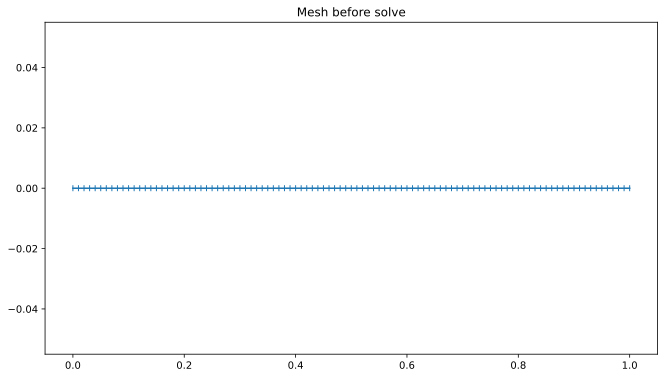



norm(u) before solve =  0.5773502691896258

  0 SNES Function norm 4.468228863302e+00
  1 SNES Function norm 6.643846192539e-13

norm(u) after solve =  0.6709599664689806





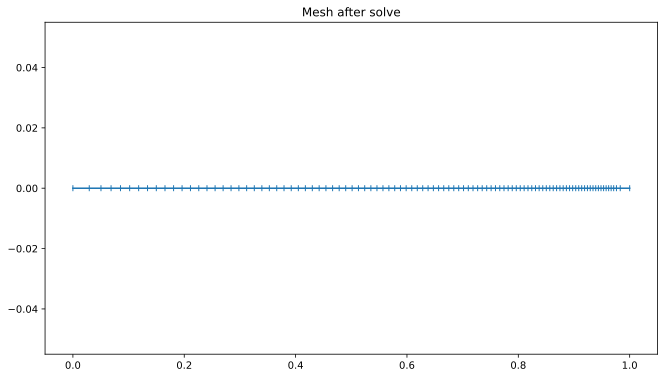



physical solve
__________________________________________________

norm(u) before solve =  1.7526598909090965

  0 SNES Function norm 1.119366477079e+02
  1 SNES Function norm 6.721030258344e-13

norm(u) after solve =  1.9466192220538543





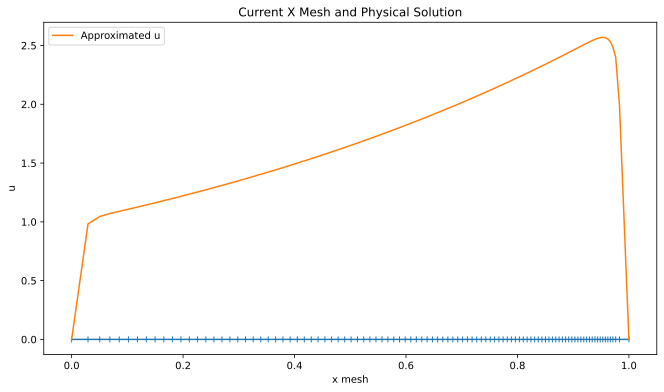




mesh update
__________________________________________________

norm(u) before solve =  0.5773502691896258

  0 SNES Function norm 1.288350221059e-02
  1 SNES Function norm 2.894024422650e-18

norm(u) after solve =  0.6709599664689806

  0 SNES Function norm 4.468228863302e+00
  1 SNES Function norm 1.240714241452e+00




MP ITERATION
__________________________________________________

mesh solve
__________________________________________________





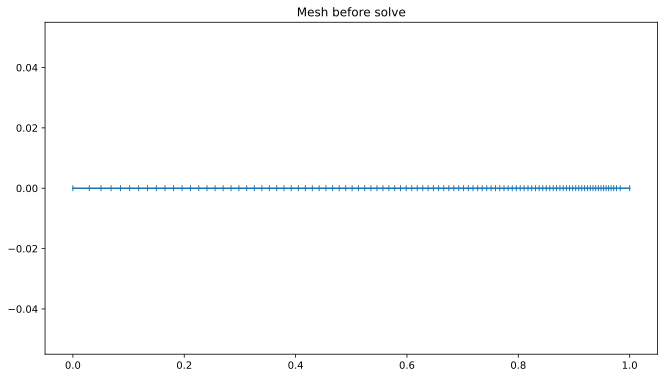



norm(u) before solve =  0.6709599664689806

  0 SNES Function norm 1.240714241452e+00
  1 SNES Function norm 8.462159221890e-13

norm(u) after solve =  0.6703534674861175





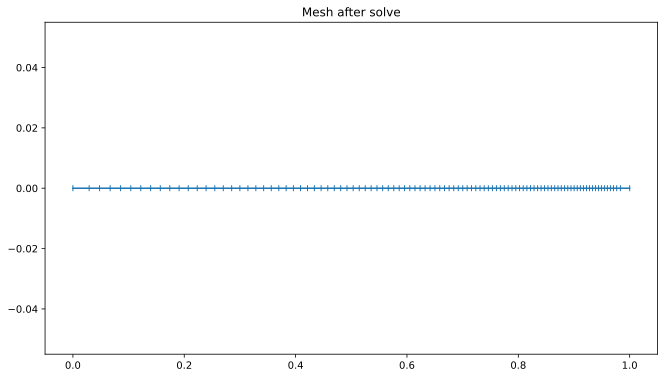



physical solve
__________________________________________________

norm(u) before solve =  1.9466192220538543

  0 SNES Function norm 5.043215335442e+00
  1 SNES Function norm 5.246958824818e-13

norm(u) after solve =  1.9449546522919041





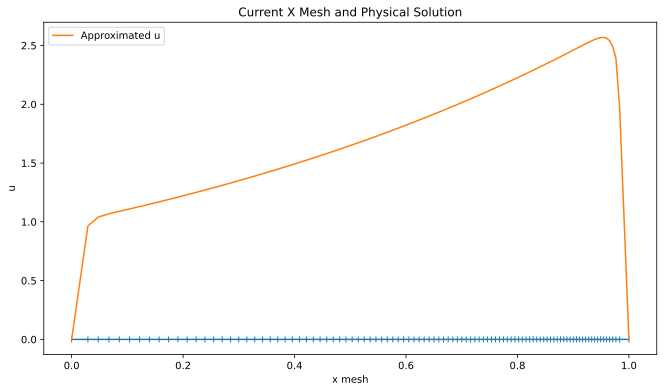




mesh update
__________________________________________________

norm(u) before solve =  0.6709599664689806

  0 SNES Function norm 9.976097089432e-04
  1 SNES Function norm 1.334631219056e-18

norm(u) after solve =  0.6703534674861175

  2 SNES Function norm 8.523266956523e-02




MP ITERATION
__________________________________________________

mesh solve
__________________________________________________





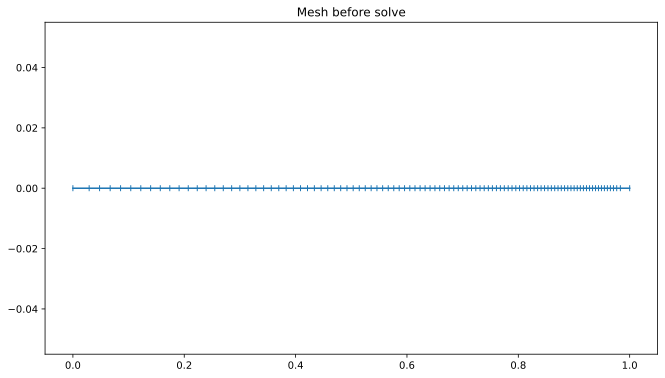



norm(u) before solve =  0.6703534674861175

  0 SNES Function norm 8.523266956523e-02
  1 SNES Function norm 6.876196216322e-13

norm(u) after solve =  0.6681394300879088





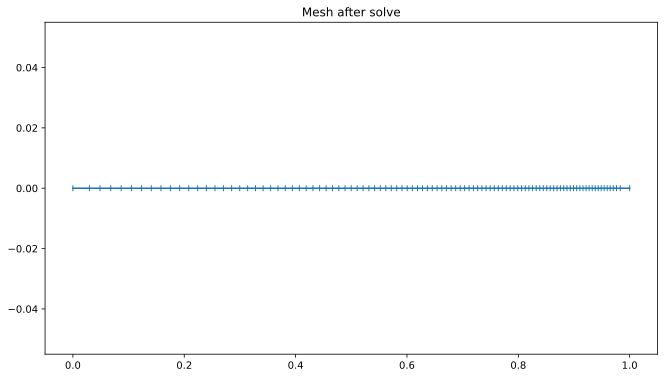



physical solve
__________________________________________________

norm(u) before solve =  1.9449546522919041

  0 SNES Function norm 1.987050893402e+00
  1 SNES Function norm 5.620431458593e-13

norm(u) after solve =  1.9409111997183208





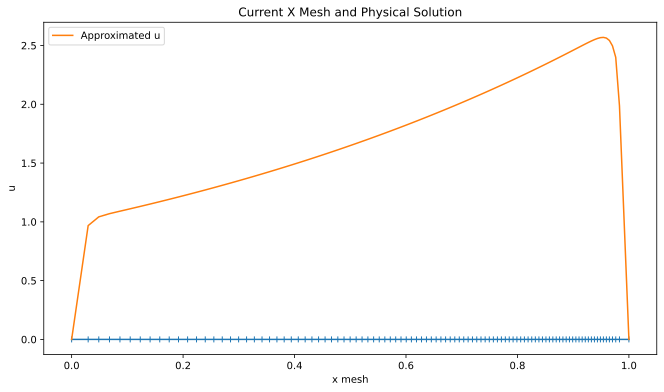




mesh update
__________________________________________________

norm(u) before solve =  0.6703534674861175

  0 SNES Function norm 3.030358127812e-04
  1 SNES Function norm 1.492832630441e-18

norm(u) after solve =  0.6681394300879088

  3 SNES Function norm 2.371270981891e-02




MP ITERATION
__________________________________________________

mesh solve
__________________________________________________





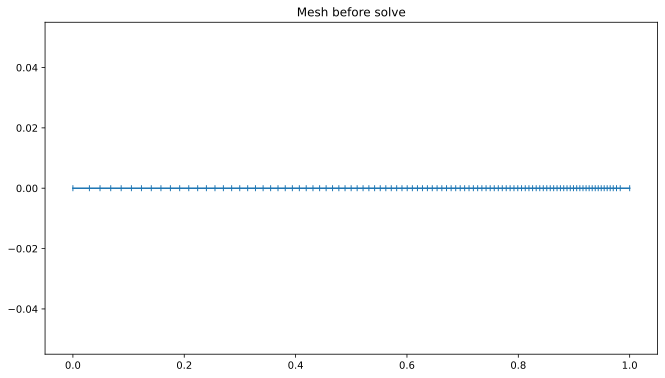



norm(u) before solve =  0.6681394300879088

  0 SNES Function norm 2.371270981891e-02
  1 SNES Function norm 6.463164267571e-13

norm(u) after solve =  0.668034699787585





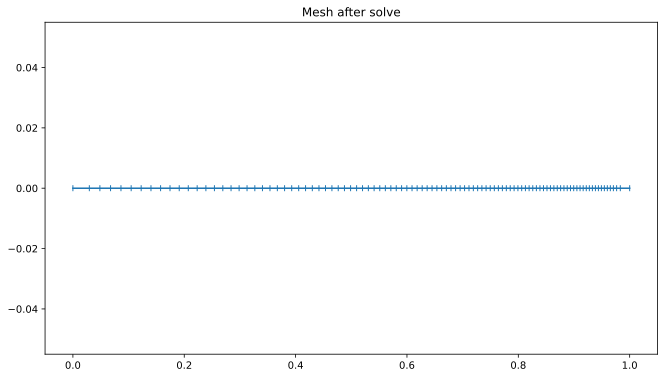



physical solve
__________________________________________________

norm(u) before solve =  1.9409111997183208

  0 SNES Function norm 1.232881974469e+00
  1 SNES Function norm 3.754946732330e-13

norm(u) after solve =  1.940476473304617





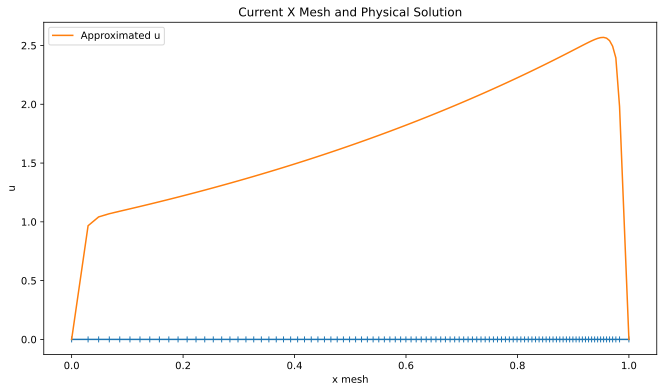




mesh update
__________________________________________________

norm(u) before solve =  0.6681394300879088

  0 SNES Function norm 6.934233649288e-05
  1 SNES Function norm 8.615174438355e-19

norm(u) after solve =  0.668034699787585

  4 SNES Function norm 1.193073973099e-02




MP ITERATION
__________________________________________________

mesh solve
__________________________________________________





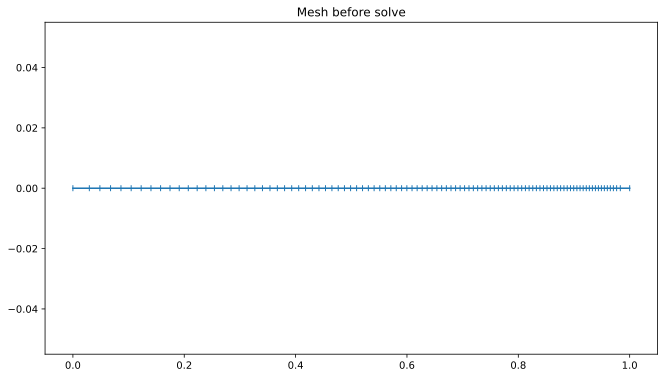



norm(u) before solve =  0.668034699787585

  0 SNES Function norm 1.193073973099e-02
  1 SNES Function norm 8.063306394443e-13

norm(u) after solve =  0.6681117804876747





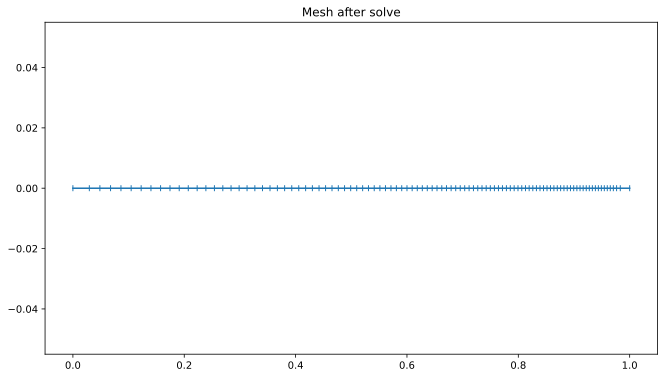



physical solve
__________________________________________________

norm(u) before solve =  1.940476473304617

  0 SNES Function norm 4.632877266113e-01
  1 SNES Function norm 4.268678359633e-13

norm(u) after solve =  1.9407100576611902





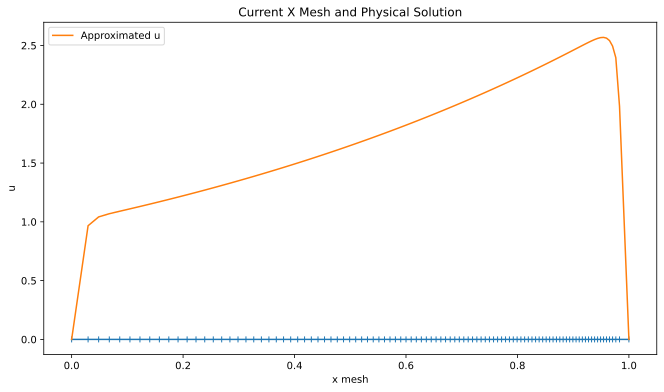




mesh update
__________________________________________________

norm(u) before solve =  0.668034699787585

  0 SNES Function norm 1.417462781173e-05
  1 SNES Function norm 1.053919080479e-18

norm(u) after solve =  0.6681117804876747

  5 SNES Function norm 4.138506331834e-03




MP ITERATION
__________________________________________________

mesh solve
__________________________________________________





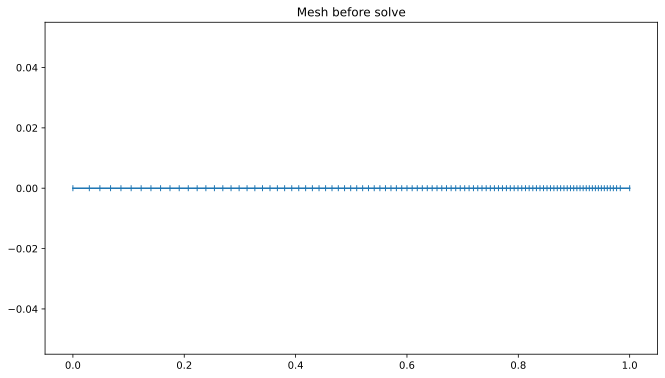



norm(u) before solve =  0.6681117804876747

  0 SNES Function norm 4.138506331834e-03
  1 SNES Function norm 7.074955785961e-13

norm(u) after solve =  0.6681400395238775





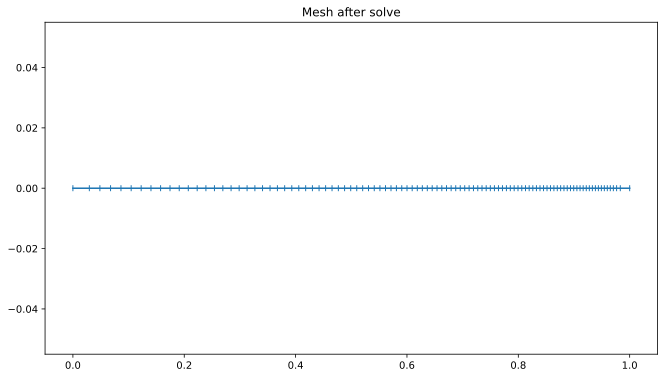



physical solve
__________________________________________________

norm(u) before solve =  1.9407100576611902

  0 SNES Function norm 1.788286651644e-01
  1 SNES Function norm 5.070391174350e-13

norm(u) after solve =  1.940735508833688





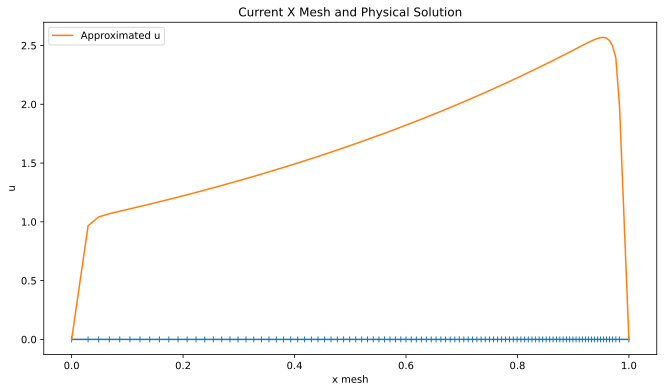




mesh update
__________________________________________________

norm(u) before solve =  0.6681117804876747

  0 SNES Function norm 4.001519609237e-06
  1 SNES Function norm 1.466493585345e-18

norm(u) after solve =  0.6681400395238775

  6 SNES Function norm 1.619335933630e-03




MP ITERATION
__________________________________________________

mesh solve
__________________________________________________





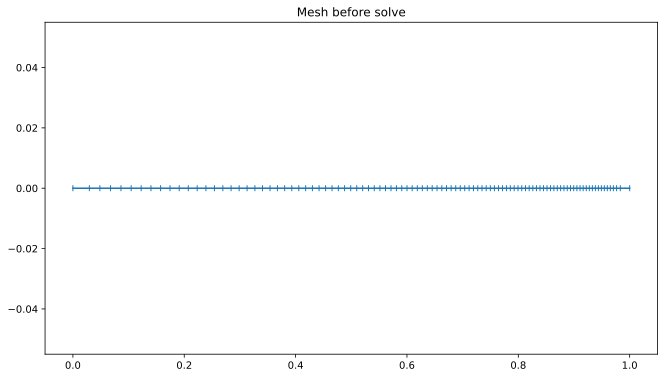



norm(u) before solve =  0.6681400395238775

  0 SNES Function norm 1.619335933630e-03
  1 SNES Function norm 7.545823192849e-13

norm(u) after solve =  0.6681262563206873





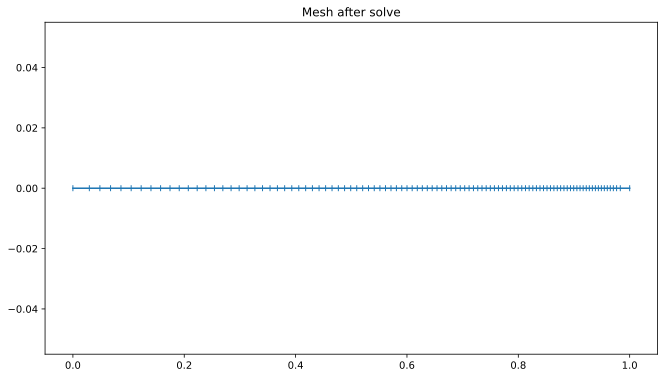



physical solve
__________________________________________________

norm(u) before solve =  1.940735508833688

  0 SNES Function norm 8.189078364315e-02
  1 SNES Function norm 5.635566662879e-13

norm(u) after solve =  1.9407225049283905





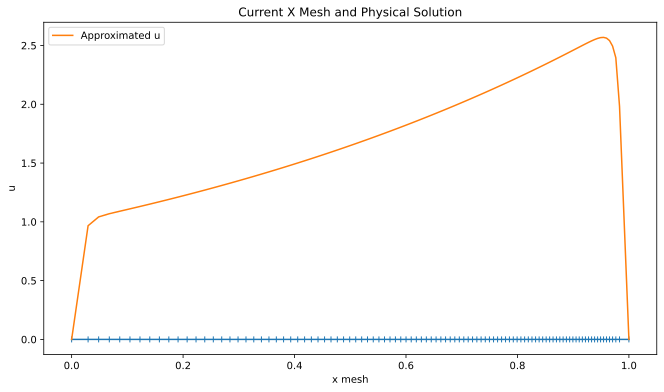




mesh update
__________________________________________________

norm(u) before solve =  0.6681400395238775

  0 SNES Function norm 1.501454745322e-06
  1 SNES Function norm 6.947516947047e-19

norm(u) after solve =  0.6681262563206873

  7 SNES Function norm 7.546980918687e-04




MP ITERATION
__________________________________________________

mesh solve
__________________________________________________





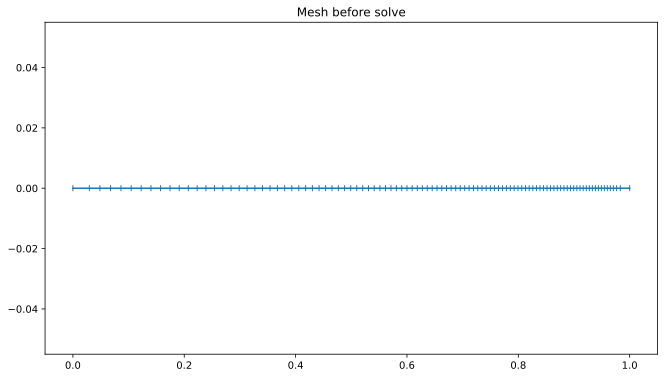



norm(u) before solve =  0.6681262563206873

  0 SNES Function norm 7.546980918687e-04
  1 SNES Function norm 7.770841714554e-13

norm(u) after solve =  0.6681293229675982





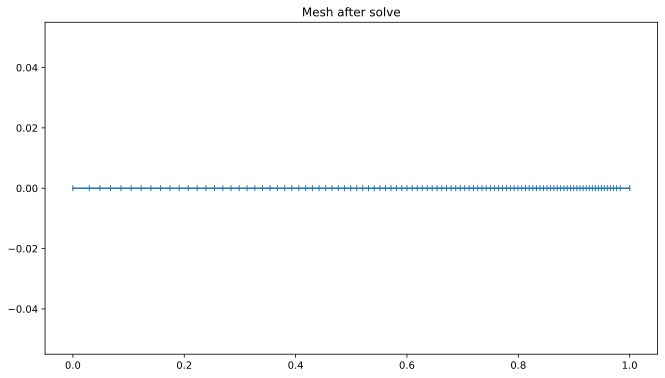



physical solve
__________________________________________________

norm(u) before solve =  1.9407225049283905

  0 SNES Function norm 3.730791637621e-02
  1 SNES Function norm 4.973213096775e-13

norm(u) after solve =  1.9407220581707572





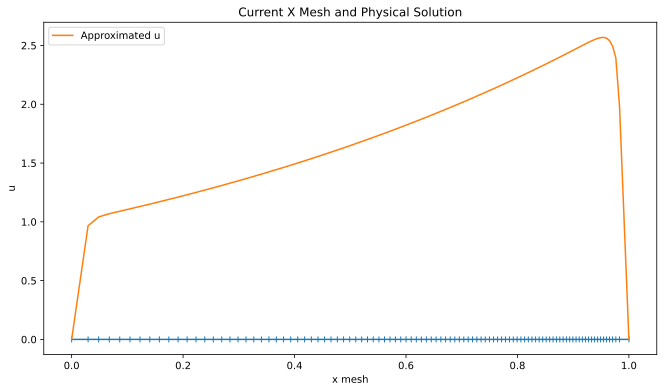




mesh update
__________________________________________________

norm(u) before solve =  0.6681262563206873

  0 SNES Function norm 4.289371188981e-07
  1 SNES Function norm 1.199714247106e-18

norm(u) after solve =  0.6681293229675982

  8 SNES Function norm 3.410173478682e-04




MP ITERATION
__________________________________________________

mesh solve
__________________________________________________





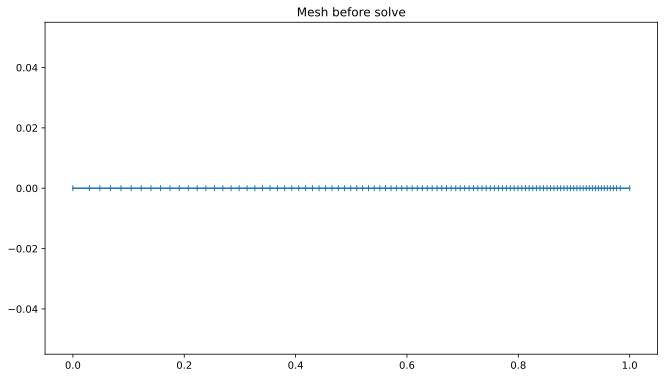



norm(u) before solve =  0.6681293229675982

  0 SNES Function norm 3.410173478682e-04
  1 SNES Function norm 7.336166915046e-13

norm(u) after solve =  0.66812796572258





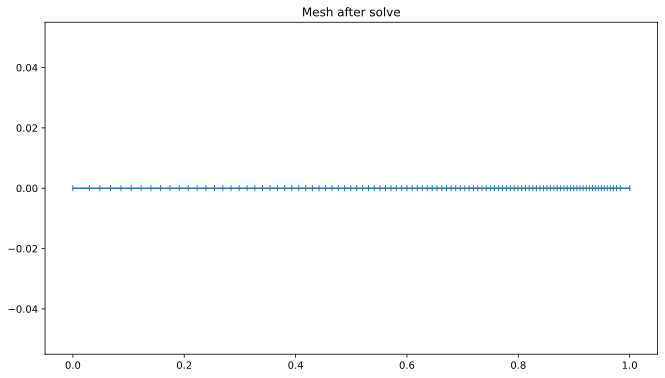



physical solve
__________________________________________________

norm(u) before solve =  1.9407220581707572

  0 SNES Function norm 1.627206047376e-02
  1 SNES Function norm 4.900506454620e-13

norm(u) after solve =  1.9407222005142641





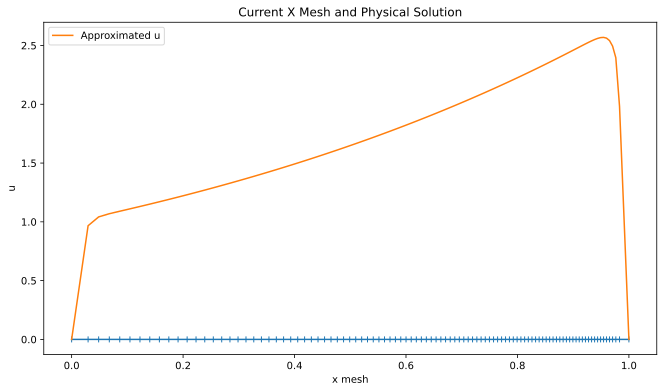




mesh update
__________________________________________________

norm(u) before solve =  0.6681293229675982

  0 SNES Function norm 1.615115939825e-07
  1 SNES Function norm 1.121306577953e-18

norm(u) after solve =  0.66812796572258

  9 SNES Function norm 1.482062264817e-04




MP ITERATION
__________________________________________________

mesh solve
__________________________________________________





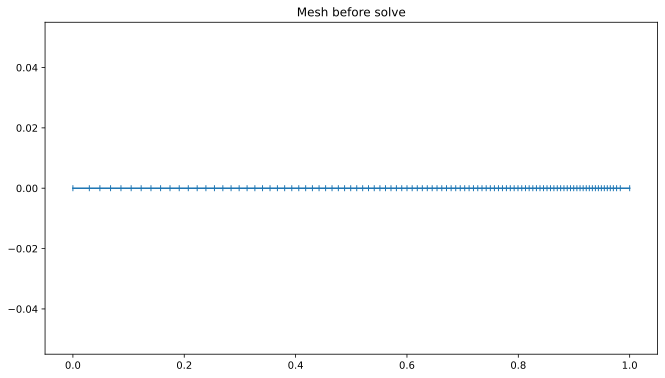



norm(u) before solve =  0.66812796572258

  0 SNES Function norm 1.482062264817e-04
  1 SNES Function norm 5.373897820997e-13

norm(u) after solve =  0.6681287174359293





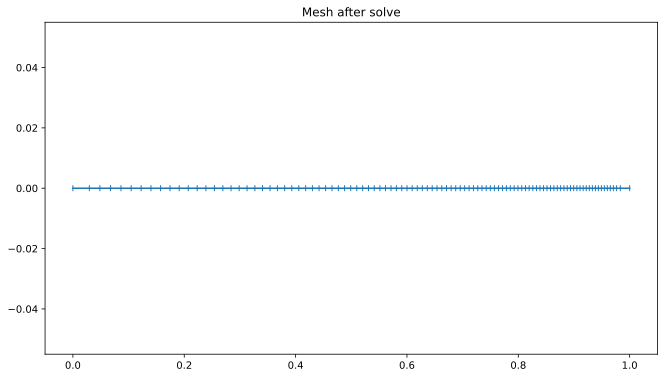



physical solve
__________________________________________________

norm(u) before solve =  1.9407222005142641

  0 SNES Function norm 7.129287147965e-03
  1 SNES Function norm 5.170830573418e-13

norm(u) after solve =  1.9407224499505584





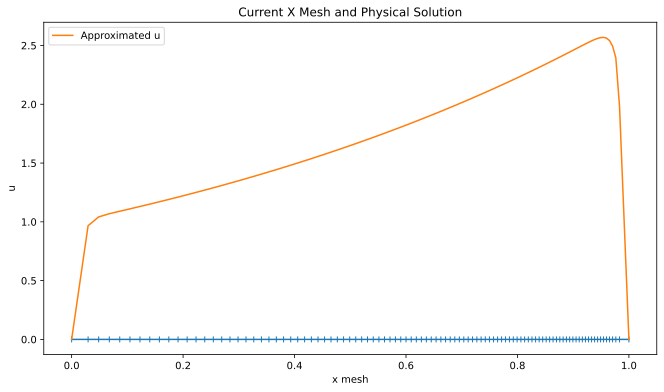




mesh update
__________________________________________________

norm(u) before solve =  0.66812796572258

  0 SNES Function norm 8.172815120883e-08
  1 SNES Function norm 1.120170347274e-18

norm(u) after solve =  0.6681287174359293

 10 SNES Function norm 6.504326167856e-05


Solver failed because of the following message:
Nonlinear solve failed to converge after 10 nonlinear iterations.
Reason:
   DIVERGED_MAX_IT



In [13]:
# MP ITERATION
################################################


# Retrieve our functions
x, u, x_old = split(xux)
y, v, y_old = split(yvy)



# Compute M
M = 1 + u**2



# jacobian based on current x
Jm = x.dx(0) #dx/dxi


# Physical PDE
f = (eps**2*(exp(2/eps) - 1)*exp(x*(eps + 1)/eps) -\
    (-(exp((eps - 1)/eps) - 1)*exp(1/eps) +\
     (exp((eps + 1)/eps) - 1)*exp((2*x - 1)/eps))*exp(1/eps))*exp(-x/eps)/(eps**2*(eps**2 - 1)*(exp(2/eps) - 1))


u_deriv = (1/Jm) * u.dx(0) # transform to du/dx
v_deriv = (1/Jm) * v.dx(0) # transform to dv/dx

a_p = (u_deriv * v_deriv)* Jm * dx # transform dxi to dx
L_p = (f * v) * Jm * dx #transform dxi to dx


# y' where y is test for x
y_pr_term = y.dx(0)


# Total form
F = (M * Jm * y_pr_term)*dx + (a_p - L_p) + (x-x_old)*y_old*dx



# bc's - again, concerning for physical soln in HER3
bcx0 = DirichletBC(W.sub(0), Constant(0), 1)
bcx1 = DirichletBC(W.sub(0), Constant(1), 2)
bcu0 = DirichletBC(W.sub(1), Constant(0), 1)
bcu1 = DirichletBC(W.sub(1), Constant(0), 2)
bcs = [bcx0, bcx1, bcu0, bcu1]



# solver parameters
FS_params = {
    'mat_type': 'nest',
    'snes_type': 'nrichardson',
    'snes_monitor': None,
    'npc_snes_type': 'python',
    'npc_snes_python_type': __name__+'.FieldsplitSNES',
    'npc_snes_fieldsplit_type': "multiplicative",
    # 'snes_linesearch_type': 'basic',
    # 'snes_linesearch_monitor': None,
    # 'snes_linesearch_damping': 0.5,
    'npc_fieldsplit_0': mesh_params,
    'npc_fieldsplit_1': lu_params,
    'npc_fieldsplit_2': lu_params,
    'snes_max_it': 10,
    # 'snes_rtol': 1e-12,
    # 'snes_atol': 1e-50,
    # 'snes_stol': 1e-12,
}




# solve the problem

try:
  NLVP = NonlinearVariationalProblem(F, xux, bcs=bcs)
  NLVS = NonlinearVariationalSolver(NLVP, solver_parameters=FS_params)
  NLVS.solve()
except Exception as e:
  print()
  print()
  print('Solver failed because of the following message:')
  print(e)
  print()

# Save our progress
x, u, x_old = xux.subfunctions